In [1]:
import os
import sys
one_level_up_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(one_level_up_dir)
import jax._src.random as prng
import jax
from jax import config, jit
import jax.numpy as jnp
import jax.random as jr
import diffrax as dfx
import matplotlib.pyplot as plt
import optax as ox
import equinox as eqx
from gpdx.systems.nonlinear_dynamics import VanDerPol
from gpdx.control.trajectory_optimizers import *
from gpdx.control.cost_functions import QuadraticCost
# from gpdx.dataset import DiffEqDataset
from gpdx.nn.node import NeuralODE, EnsembleNeuralODE
from gpdx.nn.nnvectorfield import NeuralVectorField, EnsembleNeuralVectorField

from gpdx.fit import *
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
PRNGKey = prng.KeyArray
key = jr.PRNGKey(123) 
key, subkey = jr.split(key)
%load_ext autoreload
%autoreload 2

In [2]:
from gpdx.control.control_task import CartPoleTaskv2, CartPoleTask, InvertedPendulumTask
env = CartPoleTask()
env


CartPoleTask(
  real_system=Cartpole(
    D_sys=4,
    D_control=1,
    solver=Dopri8(scan_kind=None),
    name='Cartpole',
    control_interpolator='linear',
    g=9.81,
    l=1.0,
    m=0.1,
    M=1.0,
    delta=1.0
  ),
  D_sys=4,
  D_control=1,
  R=f64[1,1],
  Q=f64[4,4],
  x_star=f64[4],
  u_star=f64[1],
  y0=f64[4],
  t0=0.0,
  tf=5.0,
  Delta_t=0.02,
  measurement_noise_std=0.0,
  lb=f64[1],
  ub=f64[1],
  state_cost=QuadraticCost(
    Q=f64[4,4],
    R=f64[1,1],
    x_star=f64[4],
    u_star=f64[1],
    transform=<function angle_normalize_cartpole>
  ),
  termination_cost=QuadraticCost(
    Q=f64[4,4],
    R=f64[1,1],
    x_star=f64[4],
    u_star=f64[1],
    transform=<function angle_normalize_cartpole>
  ),
  H=None,
  Q_f=f64[4,4],
  name='Inverted Pendulum',
  S=1.0
)

In [3]:
## data generation
t0 = env.t0
tf = env.tf
dt = env.Delta_t
dt0_dense = 0.01

num_trials = 2
num_obs = int((tf-t0)/dt)
D_in, D_out = env.D_sys+ env.D_control, env.D_sys
noise = jnp.array([jnp.sqrt(env.measurement_noise_std) for _ in range(D_out)]) # sigma^2 = 0.05 in Hegde experiment 4.1

## ode params
stepsize_controller=dfx.PIDController(rtol=1e-4, atol=1e-5, jump_ts=None)
internal_solver = dfx.Dopri5() 
dt0_internal = 1e-1


In [4]:
jnp.square(0.2)

Array(0.04, dtype=float64, weak_type=True)

traj. opt. times:  [0.3814, 0.3821, 0.3812, 0.3824, 0.3833, 0.3854, 0.3895, 0.3898, 0.3918, 0.3936]


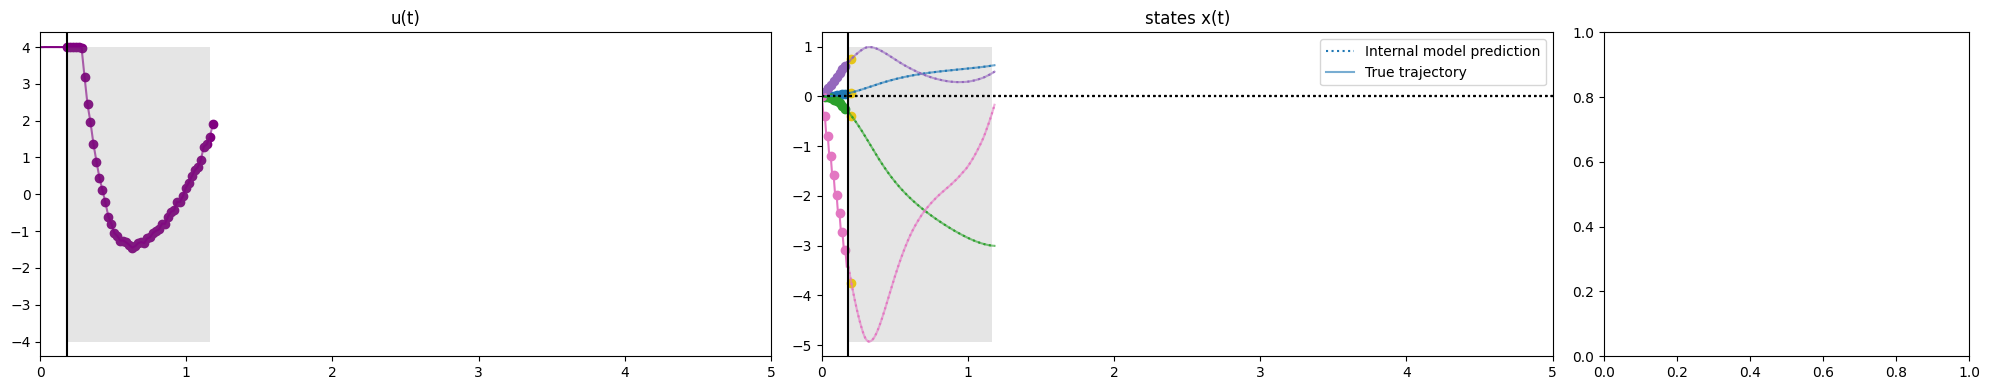

traj. opt. times:  [0.4035, 0.4013, 0.4005, 0.4017, 0.4033, 0.4028, 0.4023, 0.4011, 0.401, 0.3999]


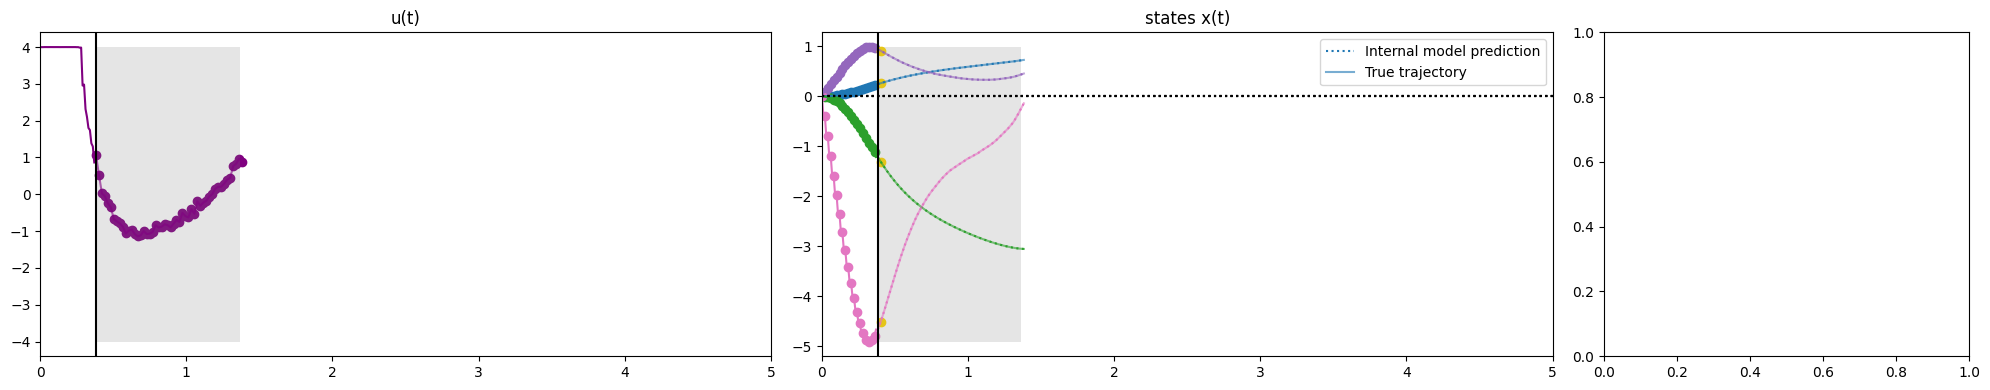

traj. opt. times:  [0.406, 0.4015, 0.4043, 0.4051, 0.4075, 0.4075, 0.4099, 0.4102, 0.411, 0.414]


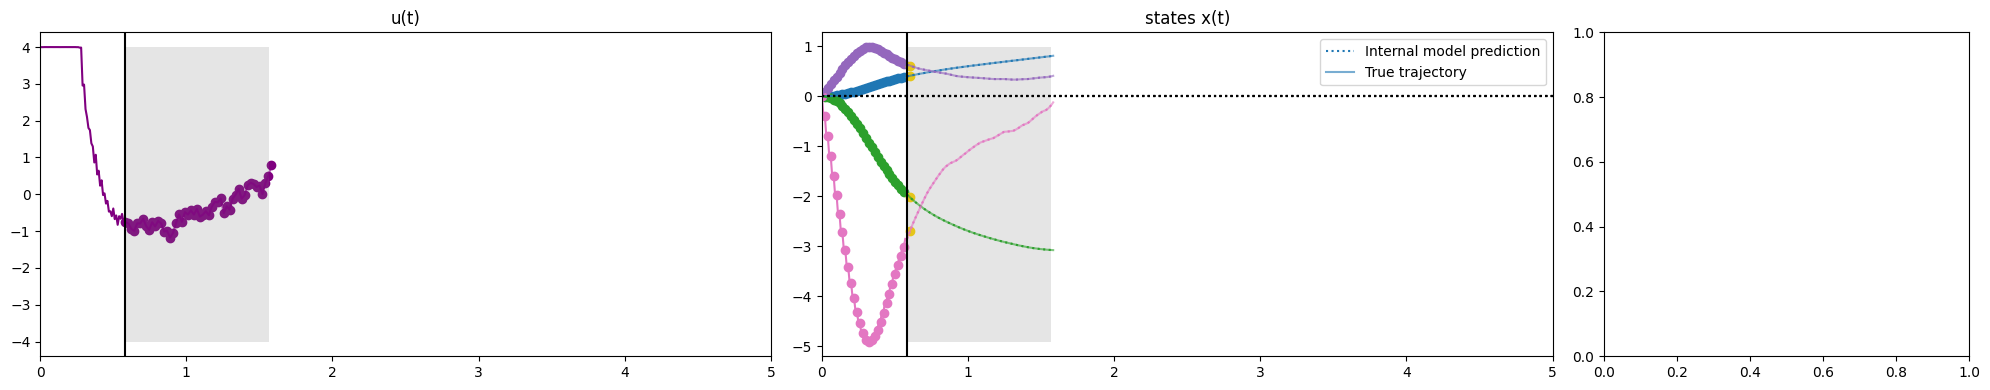

traj. opt. times:  [0.4191, 0.4147, 0.4139, 0.4176, 0.4162, 0.4207, 0.4159, 0.4147, 0.4173, 0.419]


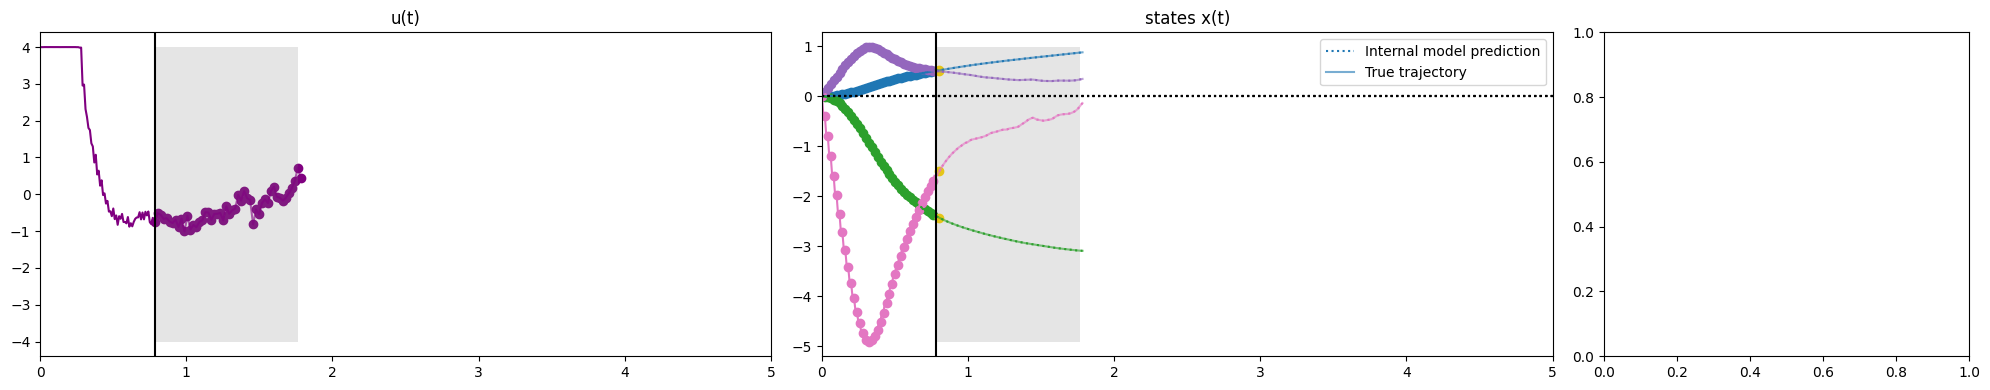

traj. opt. times:  [0.4215, 0.4157, 0.4183, 0.4193, 0.4181, 0.4159, 0.4177, 0.4204, 0.4186, 0.4165]


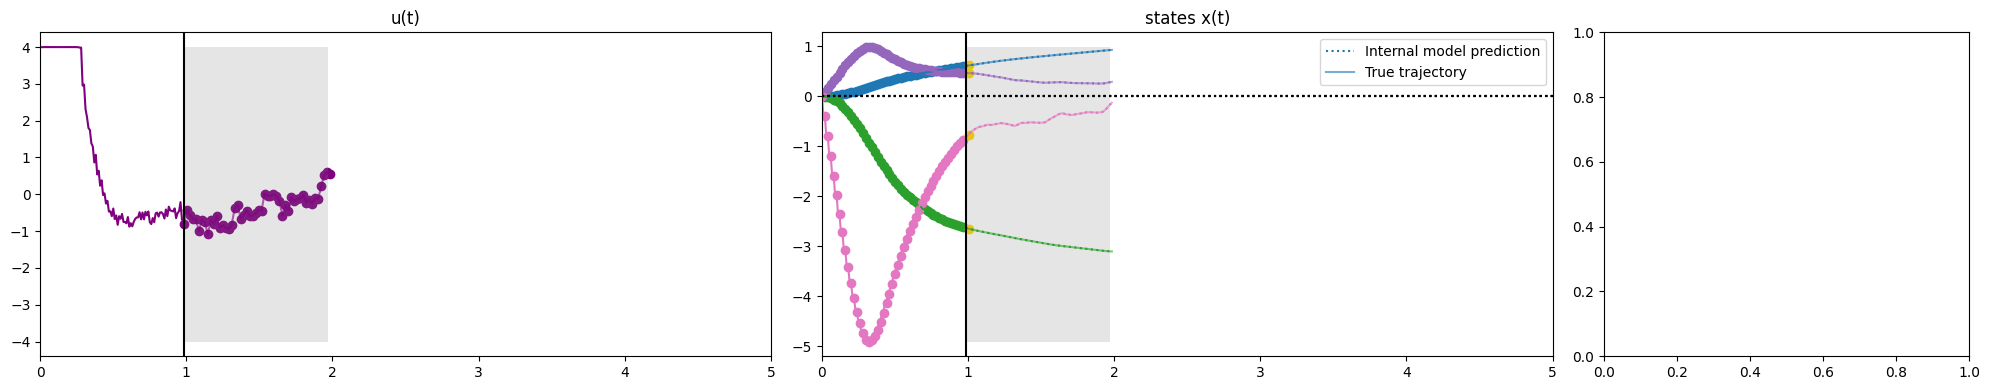

traj. opt. times:  [0.418, 0.4173, 0.419, 0.4189, 0.4211, 0.4357, 0.4274, 0.4185, 0.4171, 0.415]


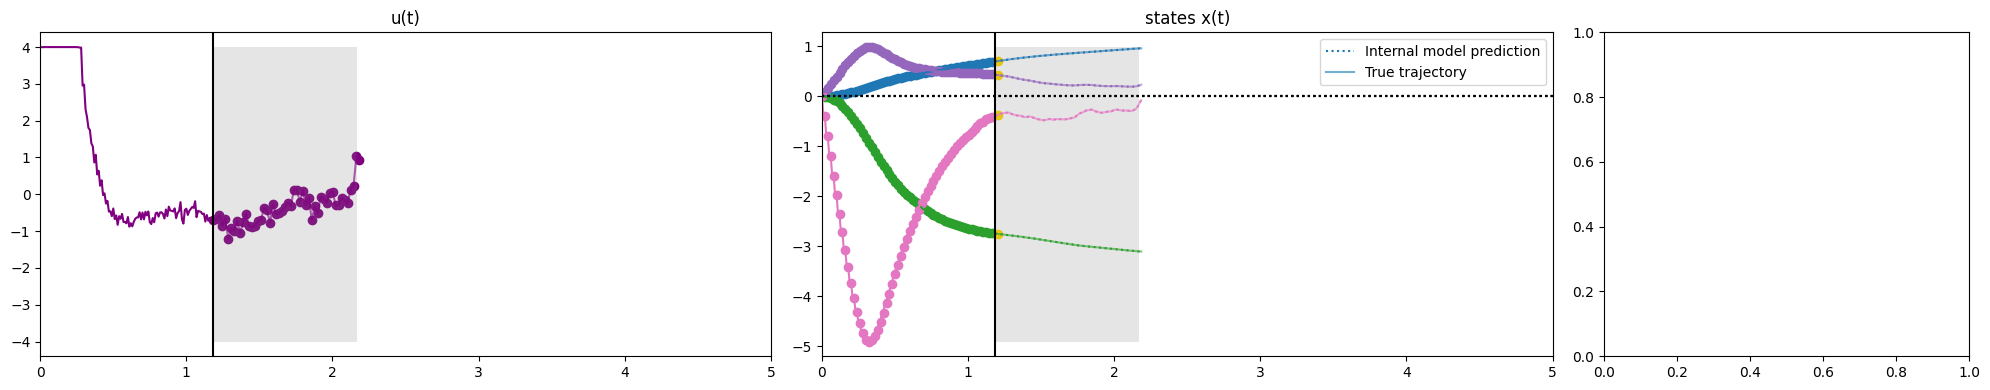

traj. opt. times:  [0.4207, 0.4143, 0.4168, 0.415, 0.4166, 0.4153, 0.4153, 0.4148, 0.4151, 0.4149]


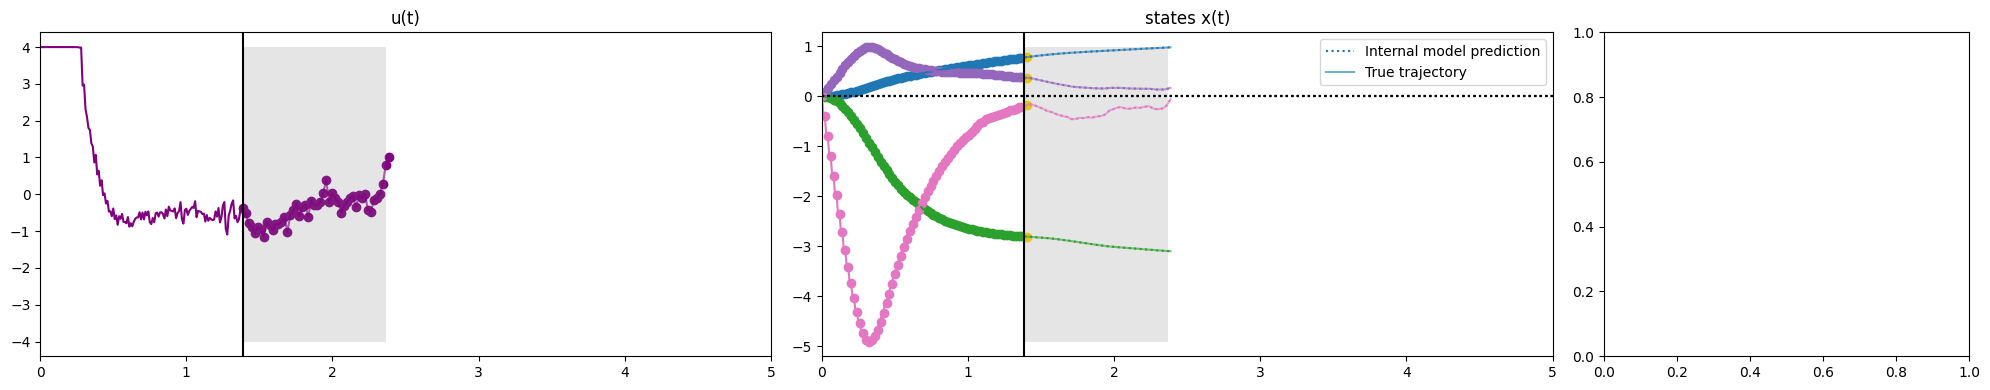

traj. opt. times:  [0.4199, 0.4149, 0.4157, 0.416, 0.415, 0.4161, 0.4167, 0.4157, 0.4171, 0.4151]


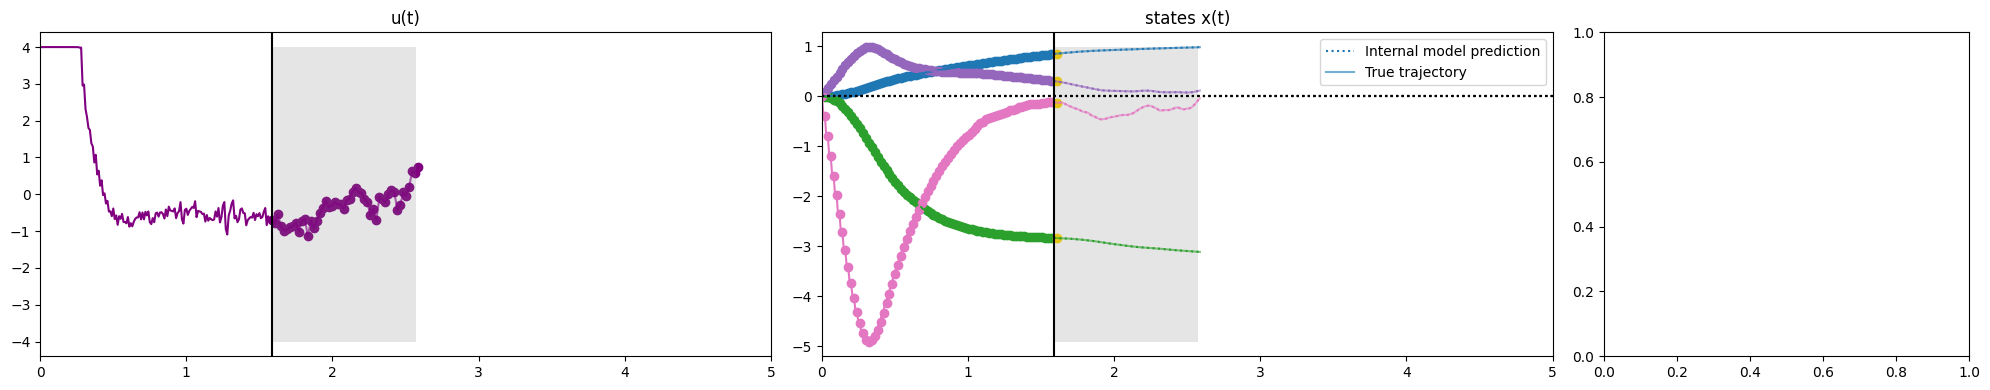

traj. opt. times:  [0.4212, 0.4178, 0.416, 0.4195, 0.4238, 0.4213, 0.4173, 0.4163, 0.419, 0.417]


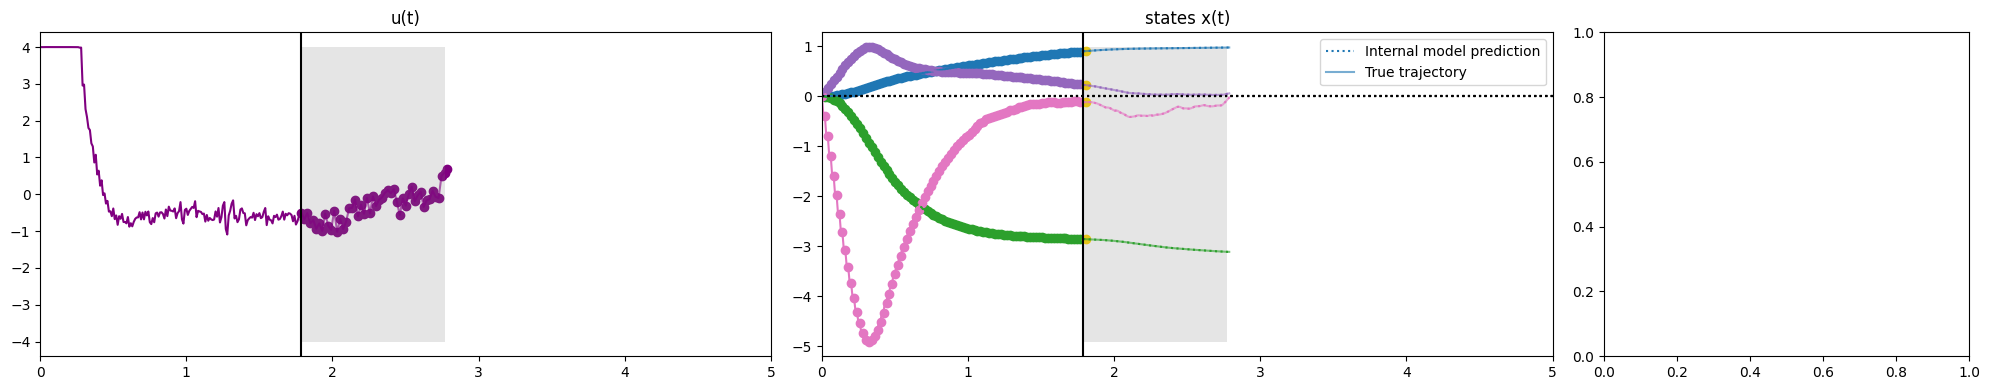

traj. opt. times:  [0.4208, 0.416, 0.4187, 0.4168, 0.4155, 0.4172, 0.4155, 0.4168, 0.4171, 0.4153]


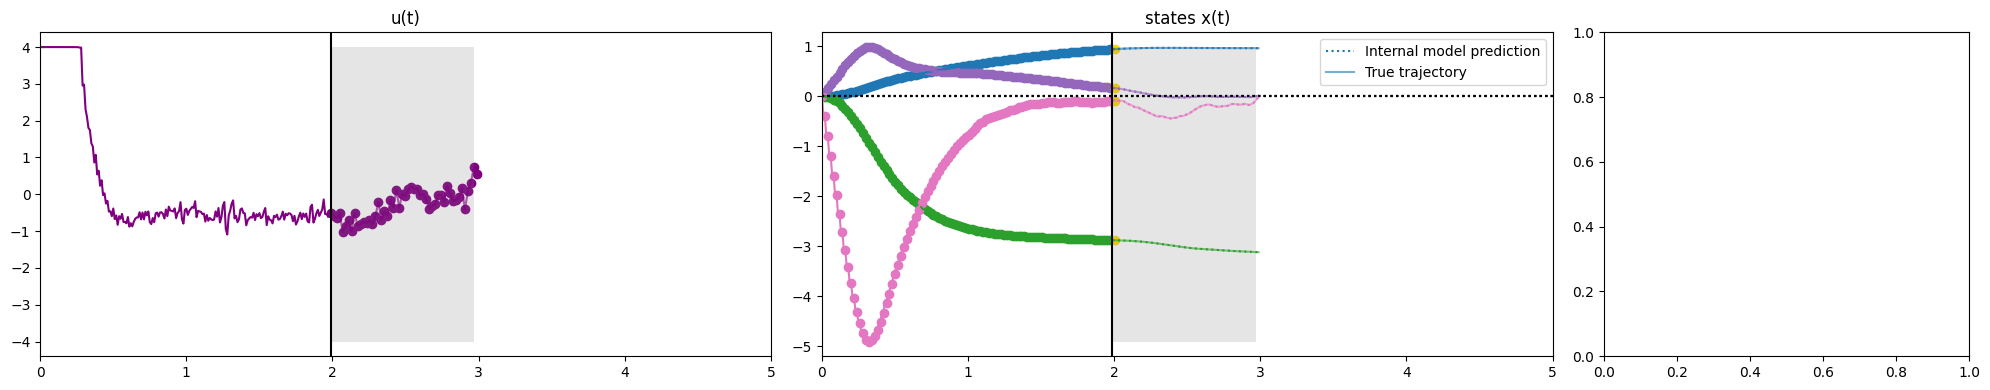

traj. opt. times:  [0.4279, 0.4227, 0.4272, 0.4218, 0.4236, 0.4159, 0.4325, 0.4303, 0.4352, 0.4103]


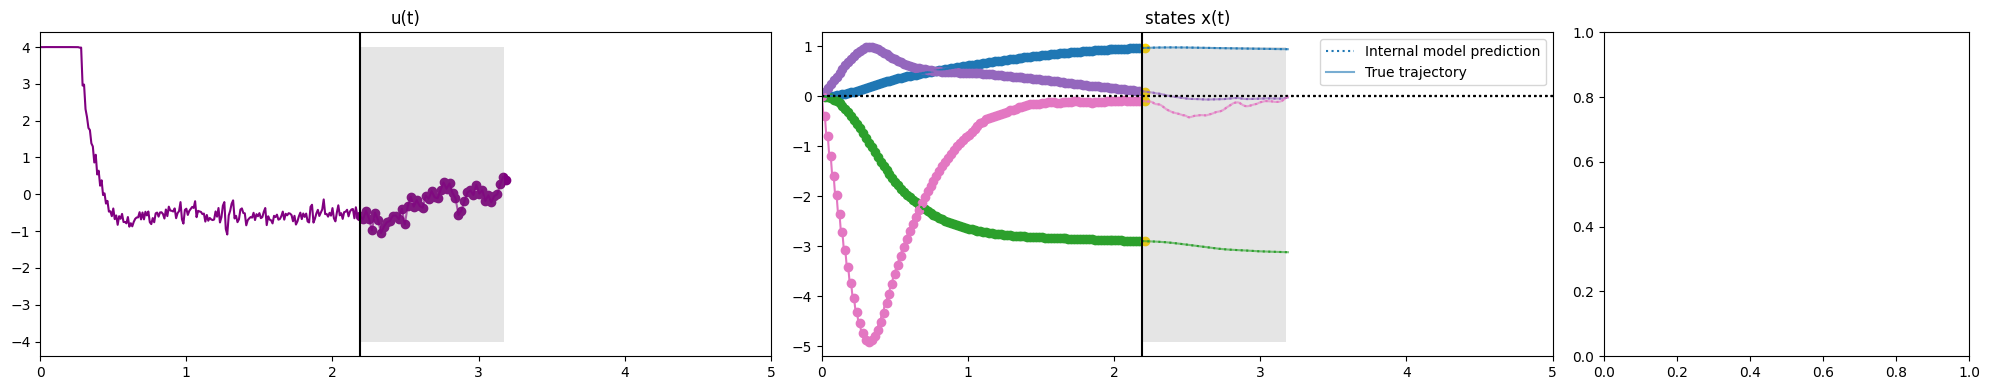

traj. opt. times:  [0.4123, 0.4085, 0.408, 0.4083, 0.4111, 0.4077, 0.4088, 0.4091, 0.4077, 0.407]


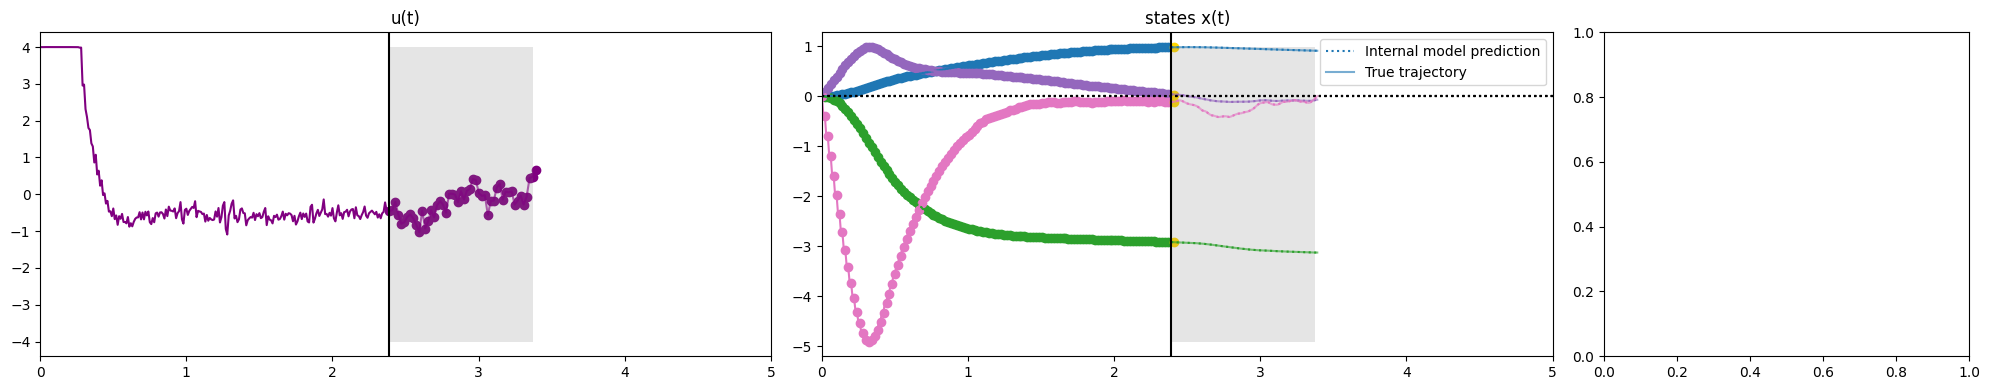

traj. opt. times:  [0.4129, 0.4061, 0.4083, 0.4086, 0.4062, 0.4059, 0.407, 0.4072, 0.4067, 0.4069]


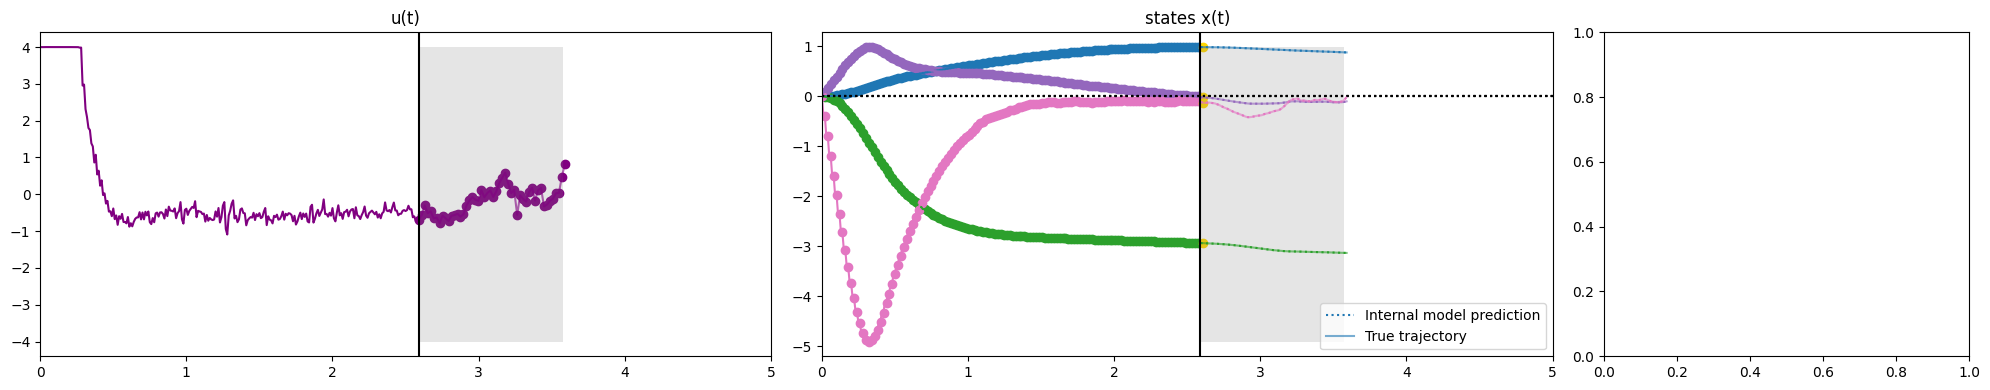

traj. opt. times:  [0.4116, 0.4084, 0.4069, 0.4071, 0.4084, 0.4083, 0.4081, 0.4076, 0.4057, 0.407]


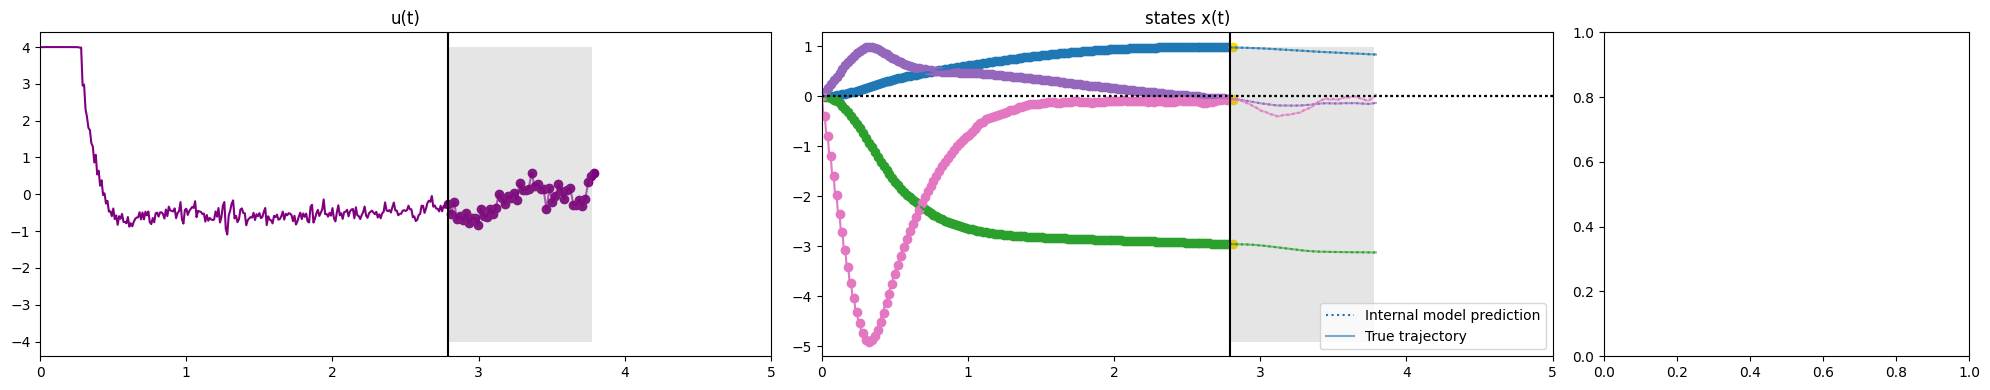

traj. opt. times:  [0.4125, 0.4052, 0.4132, 0.4068, 0.4076, 0.4081, 0.4086, 0.4071, 0.4059, 0.4066]


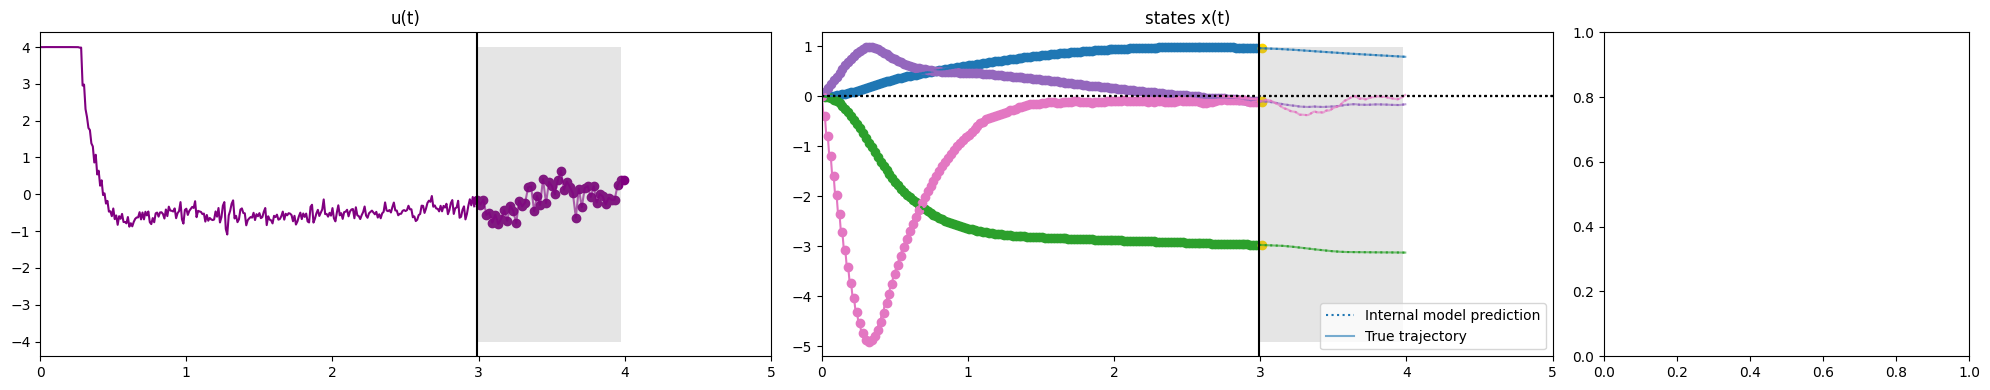

traj. opt. times:  [0.4111, 0.4076, 0.4066, 0.4091, 0.4068, 0.4062, 0.4044, 0.4045, 0.4052, 0.4056]


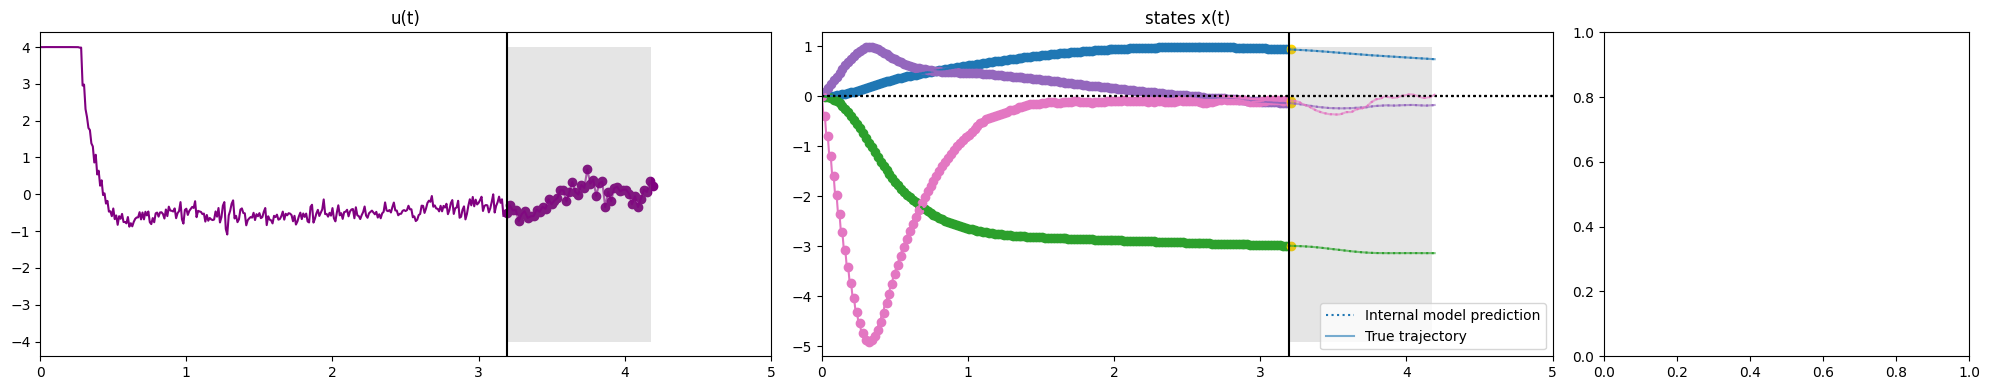

traj. opt. times:  [0.4074, 0.4022, 0.4083, 0.4016, 0.4035, 0.4031, 0.4003, 0.4008, 0.3996, 0.3983]


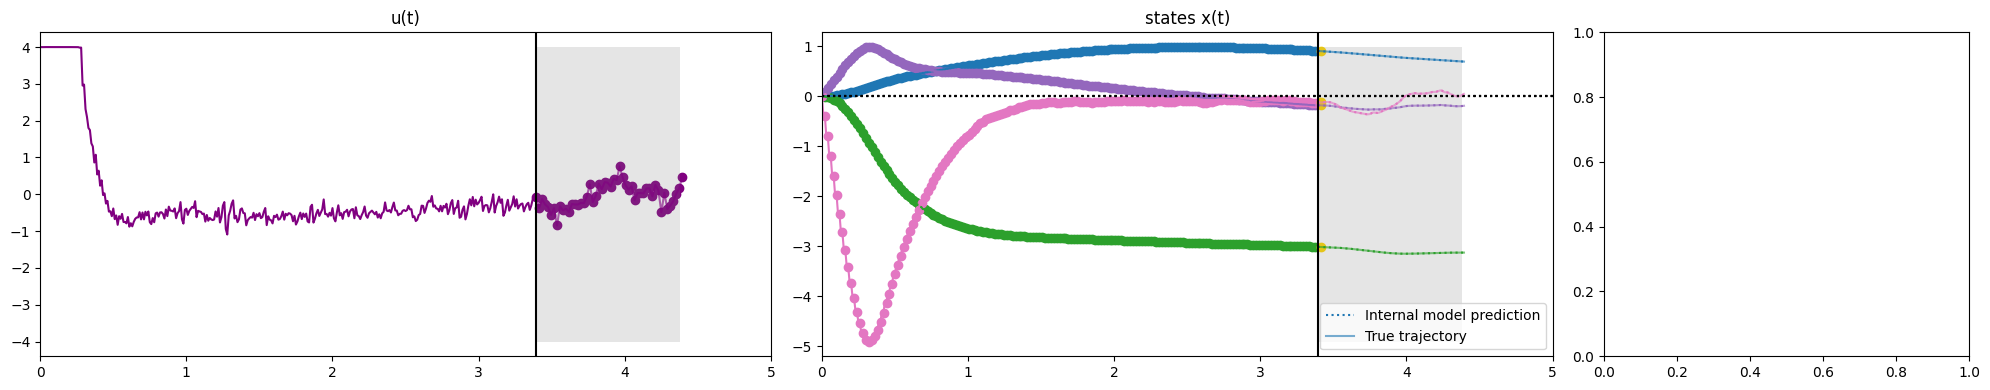

traj. opt. times:  [0.4012, 0.3961, 0.3949, 0.3953, 0.3948, 0.3944, 0.3935, 0.3937, 0.395, 0.3947]


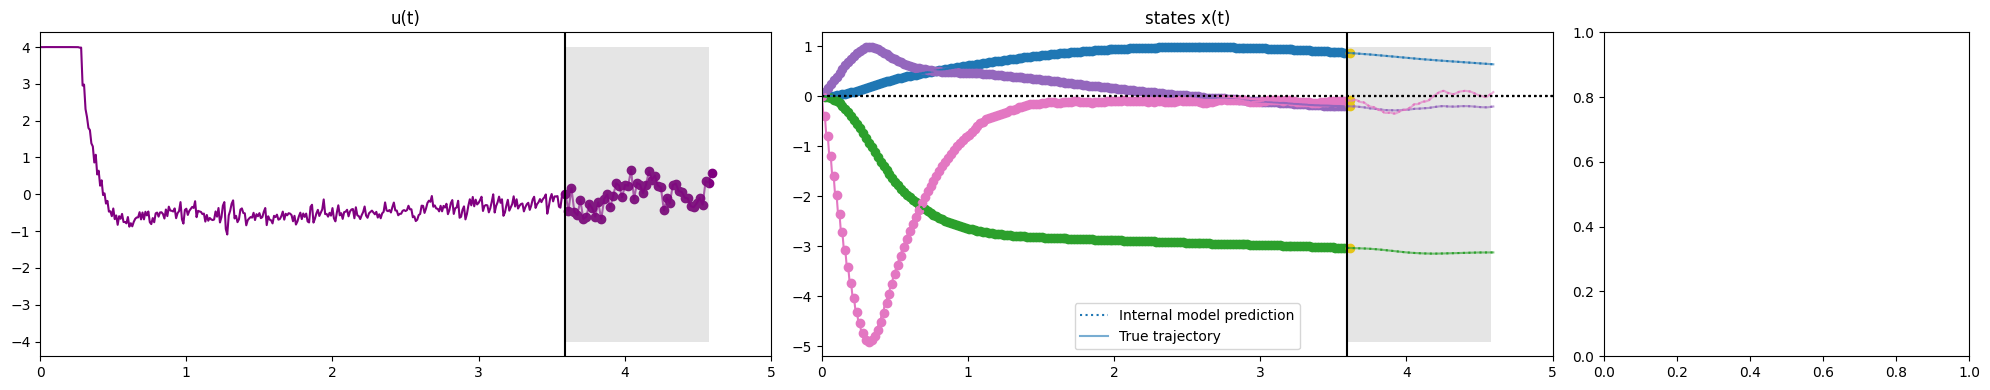

traj. opt. times:  [0.3986, 0.3958, 0.3998, 0.3945, 0.3946, 0.3941, 0.3942, 0.3953, 0.3939, 0.3941]


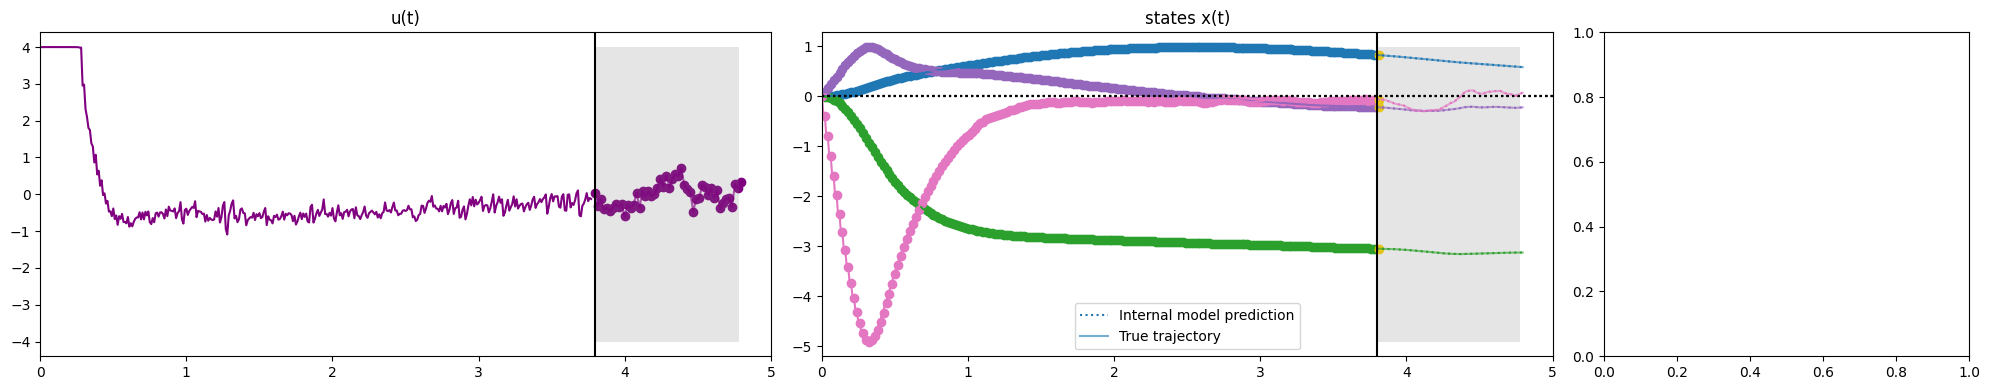

traj. opt. times:  [0.3985, 0.3982, 0.3968, 0.3947, 0.3947, 0.3971, 0.3949, 0.3952, 0.396, 0.3935]


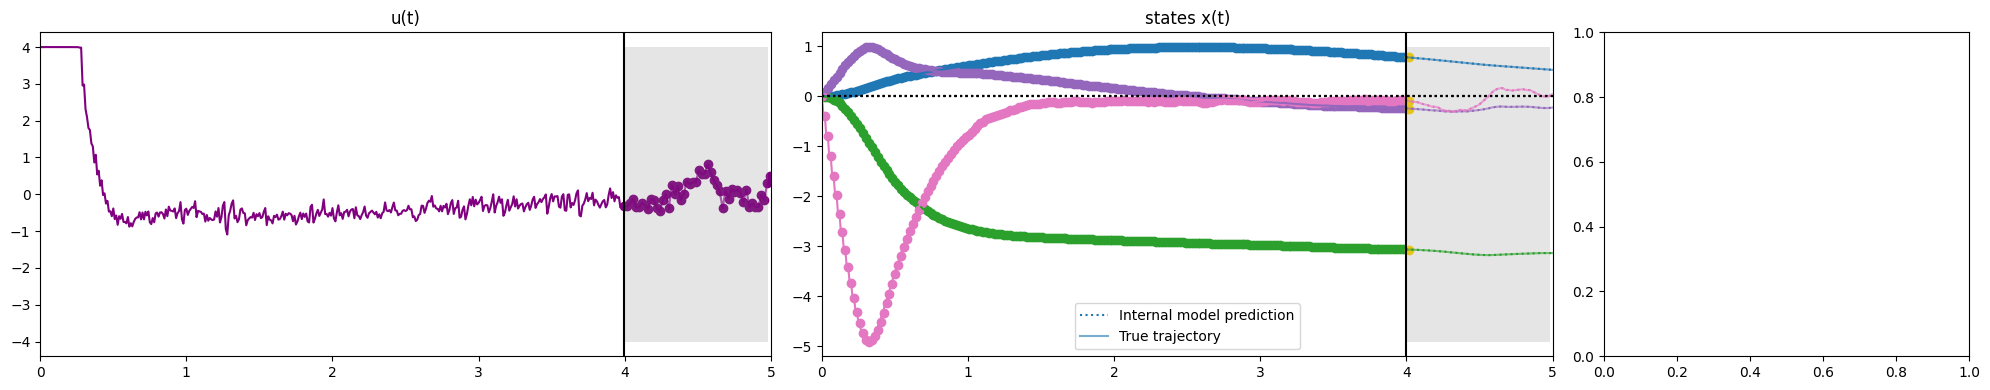

traj. opt. times:  [0.3977, 0.3957, 0.3952, 0.3953, 0.3951, 0.3951, 0.3946, 0.3959, 0.3955, 0.3959]


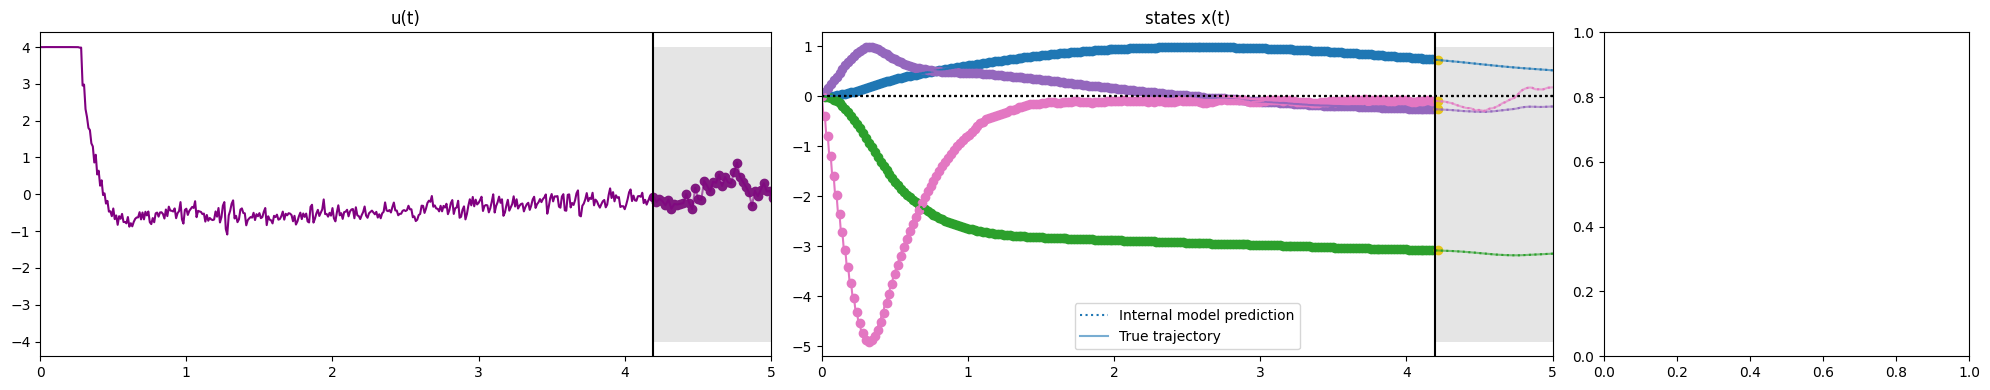

traj. opt. times:  [0.4004, 0.3945, 0.3998, 0.3957, 0.396, 0.396, 0.3957, 0.3956, 0.3961, 0.3967]


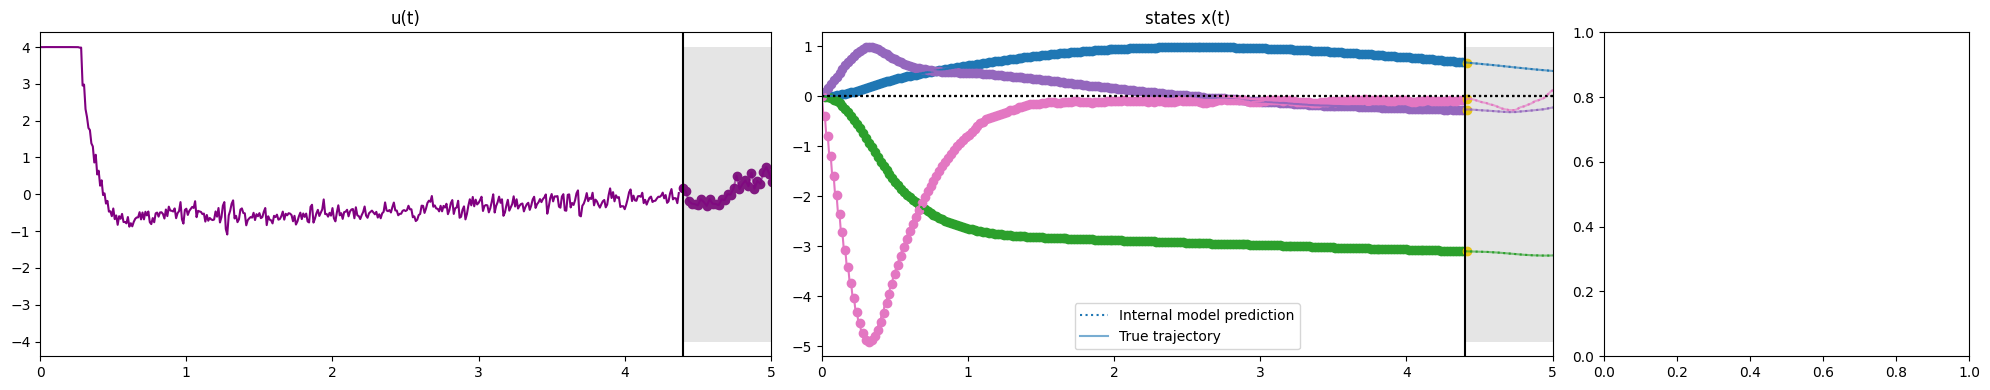

traj. opt. times:  [0.4, 0.3968, 0.3966, 0.3963, 0.395, 0.3959, 0.3957, 0.3958, 0.3976, 0.3979]


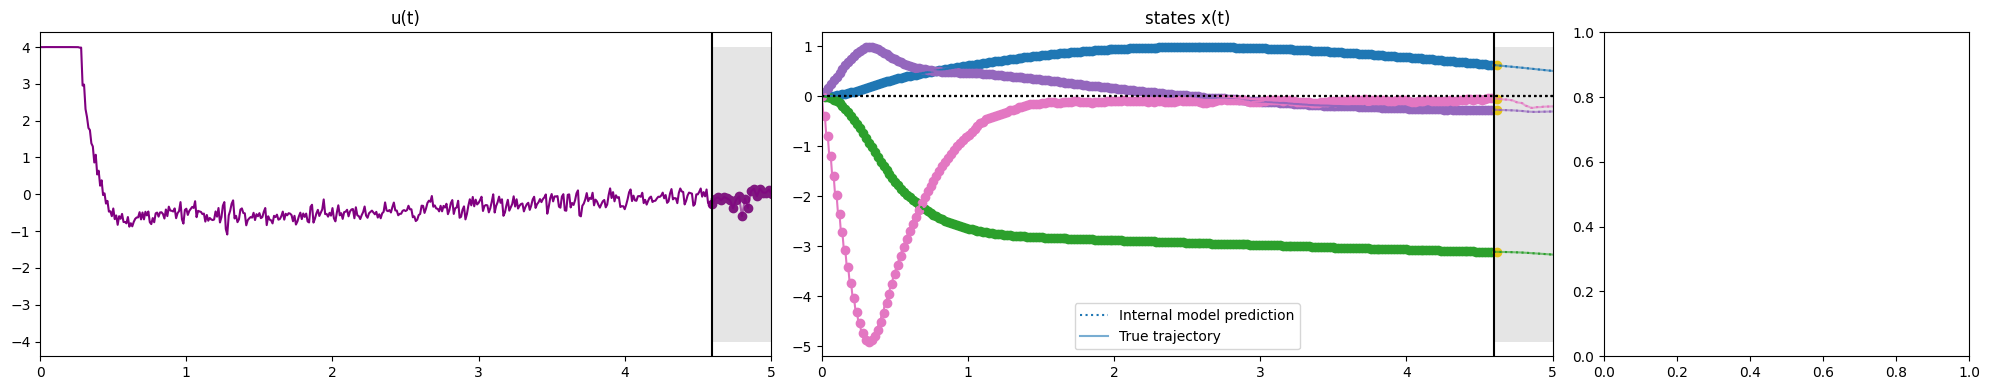

traj. opt. times:  [0.4026, 0.3981, 0.3964, 0.4018, 0.3954, 0.3966, 0.3949, 0.397, 0.3964, 0.3967]


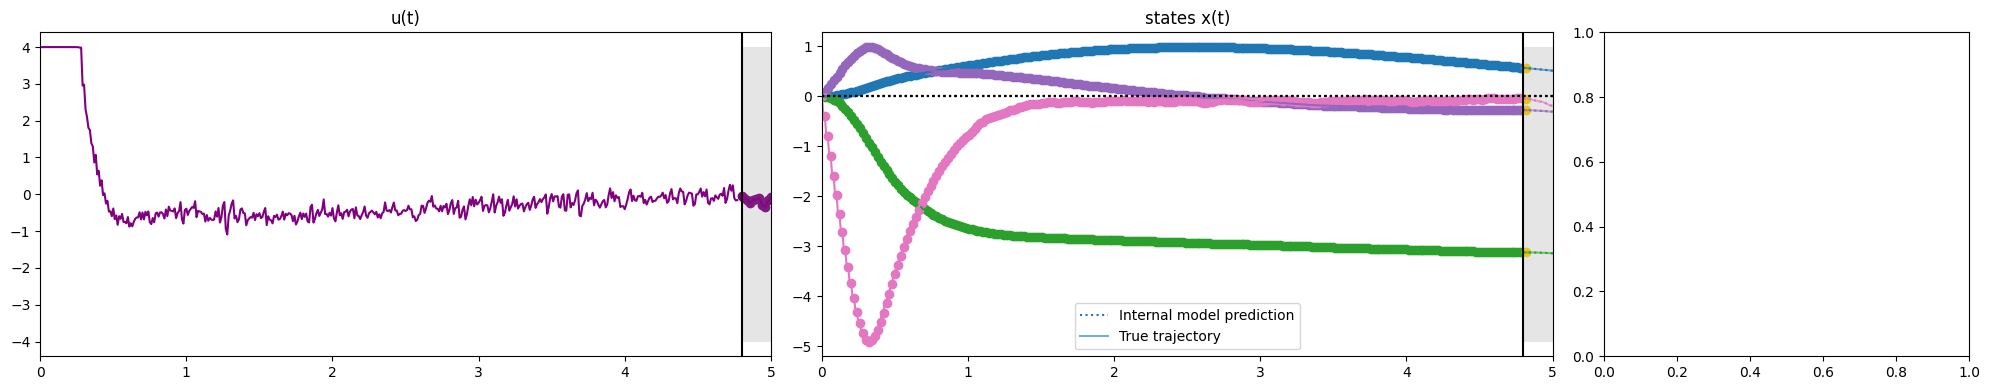

traj. opt. times:  [0.4002, 0.396, 0.3982, 0.3963, 0.4005, 0.3979, 0.3981, 0.3981, 0.3985, 0.399]


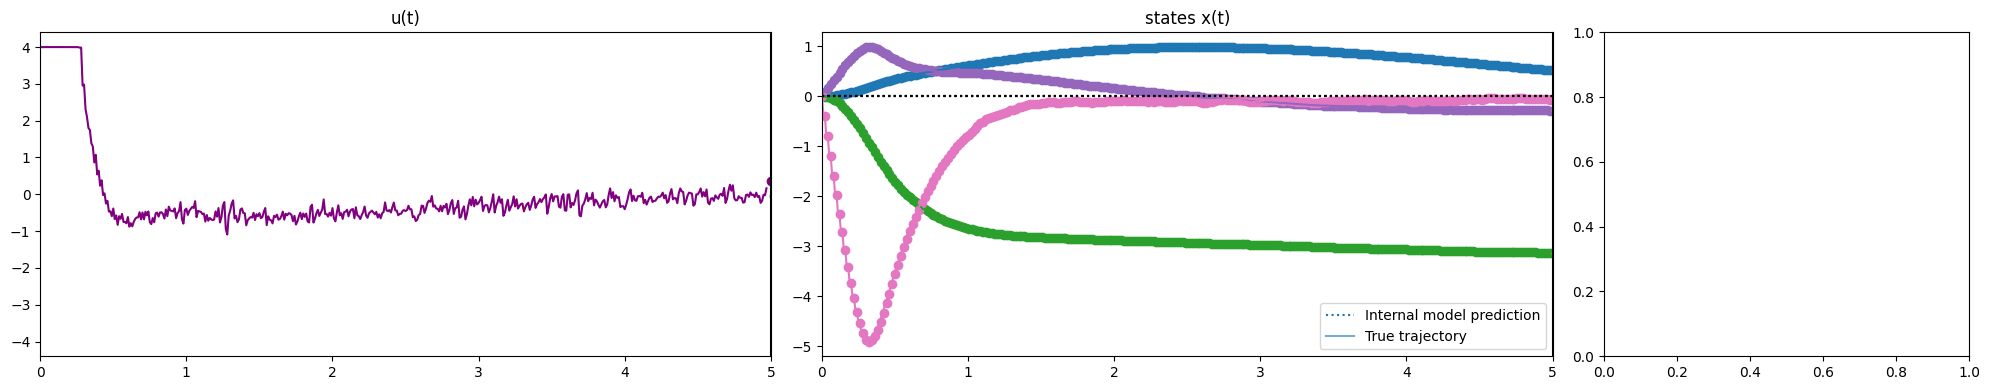

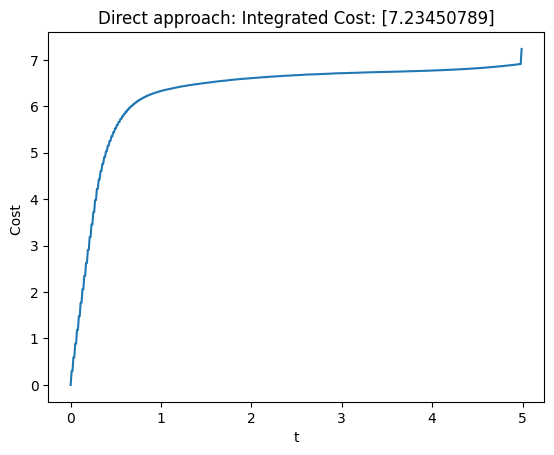

In [10]:

maxiter = 25
from gpdx.control.mpc import *
H = 1.
us_init = 0.*jr.normal(key=subkey**2, shape=(jnp.arange(0, H, env.Delta_t).shape[0], 1))
key, subkey = jr.split(key)

sqp_solver = LBFGSB(
                # step_size=0.05,
            lb=env.lb*jnp.ones_like(us_init),
            ub=env.ub*jnp.ones_like(us_init),
            maxiter=maxiter,)
cem_solver = CEM(pop_size=700,
                #   beta=1,
                 elite_size = int(0.13*700),
                 alpha=0.3,
                 init_var = .5, 
                lb=env.lb*jnp.ones_like(us_init),
                ub=env.ub*jnp.ones_like(us_init),
                maxiter=maxiter,)

true_mpc = MPC(
        traj_optimizer=cem_solver,
        real_system=env.real_system,
        internal_system=env.real_system,
        state_cost=env.state_cost,
        termination_cost=env.termination_cost,
        verbose=True,
        )

ts, ts_dense, X, Y, U, R = true_mpc.simulate(x0=env.get_initial_condition(subkey),
        ts=jnp.linspace(env.t0, env.tf, int( ((1/env.Delta_t))*(tf-t0))),
        Delta_t=env.Delta_t,
        dt0_dense=dt0_dense,
        x_star=env.x_star,
        H=H, 
        )


plt.plot(ts_dense, R)
plt.title(f'Direct approach: Integrated Cost: {R[-1]}')
plt.ylabel('Cost ')
plt.xlabel('t')
plt.show()

## Indirect approach

In [ ]:
from gpdx.control.trajectory_optimizers import PMPForward
from gpdx.control.mpc import indirect_MPC
n_segments = 5

pmp_solver = PMPForward(f=env.real_system.f,
                maxiter=maxiter,
                D_sys=env.D_sys,
                D_control=env.D_control,
                n_segments=n_segments,
                state_cost=env.state_cost,
                termination_cost=env.termination_cost,
                lb=env.lb*jnp.ones_like(us_init[0]),
                ub=env.ub*jnp.ones_like(us_init[0]),
                )
        
indirect_mpc = indirect_MPC(traj_optimizer=pmp_solver,
    real_system=env.real_system,
    internal_system=env.real_system,
    state_cost=env.state_cost,
    termination_cost=env.termination_cost,
    verbose=True,
    )

ts, ts_dense, X, Y, U, R = indirect_mpc.simulate(x0=env.get_initial_condition(subkey),
    ts=jnp.linspace(env.t0, env.tf, int( ((1/env.Delta_t))*(tf-t0))),
    Delta_t=env.Delta_t,
    dt0_internal=0.025,
    dt0_dense=dt0_dense,
    x_star=env.x_star,
    H=1,
    key=jr.PRNGKey(44))

plt.plot(ts_dense, R)
plt.title(f'Indirect approach: Integrated Cost: {R[-1]}')
plt.ylabel('Cost ')
plt.xlabel('t')
plt.show()

16/91803102 , 0.06 - 0.07 per iteration

In [ ]:
end_idx = int(ts_dense.shape[0]/1)
names = [r'$x$', r'$\sin(\theta)$', r'$\cos(\theta)$', r'$\dot{x}$', r'$\dot{\theta}$']
for i in range(env.D_sys):
    plt.plot(ts_dense[:end_idx], X[:end_idx,i], label=names[i])
plt.axhline(y=1., color='C0', linestyle=':')
plt.axhline(y=-1, color='C1', linestyle=':')
plt.axhline(y=0., color='C2', linestyle=':')
plt.axhline(y=0., color='C3', linestyle=':')
plt.axhline(y=0., color='C4', linestyle=':')
plt.legend()
plt.show()